# <font color='navy'> PREDICTING DIAMOND PRICES </font>

## Get data

### 1. Importing all libraries

In [919]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

### 2. Getting the data
* Data is dowloaded from Kaggle database - it has basic data on more than 54000 diamonds.


In [920]:
df = pd.read_csv("diamonds.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
display(df.head(3))

,carat,cut,color,clarity,depth,table,price,l,w,d
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


## <a id='data_proc'> Data pre-processing</a>

### Check if any null values present

In [921]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
l          0
w          0
d          0
dtype: int64

### Check if all expected datatypes in all columns

In [922]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
l          53940 non-null float64
w          53940 non-null float64
d          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


### List all categories of the 3 categorical columns: cut, clarity and color
> Remember, making a SET out of a series in a way means finding unique values, since a SET can have only unique values 

In [923]:
print("Cut: ",set(df["cut"]))
print("Color: ",set(df["color"]))
print("Clarity: ",set(df["clarity"]))

Cut:  {'Very Good', 'Fair', 'Ideal', 'Premium', 'Good'}
Color:  {'F', 'H', 'G', 'I', 'J', 'D', 'E'}
Clarity:  {'SI2', 'IF', 'VS1', 'VVS2', 'SI1', 'VVS1', 'VS2', 'I1'}


#### Since the data is old, we increase the price by 15% based on the price trends graphs from:
* https://www.statista.com/statistics/279053/worldwide-sales-of-polished-diamonds/
* https://www.pricescope.com/diamond-prices/diamond-prices-chart/
* https://www.pricescope.com/diamond-prices/diamond-prices-chart/

In [924]:
print(df['price'].head())
df['price'] = df['price'] *1.15
print(df['price'].head())

0    326
1    326
2    327
3    334
4    335
Name: price, dtype: int64
0    374.90
1    374.90
2    376.05
3    384.10
4    385.25
Name: price, dtype: float64


## <a id='data_viz'>Data visualisation</a>

#### 1. Pair-Plot Price vs. 4 Cs.
Read more about 4Cs at https://4cs.gia.edu/en-us/4cs-diamond-quality/ or video at https://www.diamonds.pro/education/4cs-diamonds/

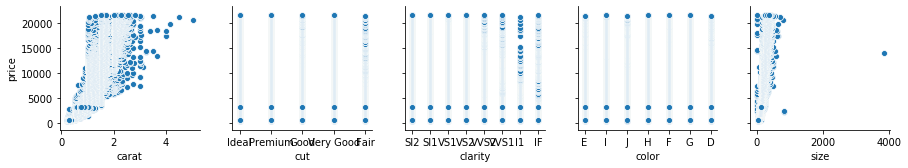

In [925]:
df['size']=df['l']*df['w']*df['d']
sns.pairplot(df, x_vars=['carat', 'cut', 'clarity', 'color', 'size'], y_vars = ['price'])
plt.show()
df.drop(['size'], axis=1, inplace=True)

#### 2. Plot histogram for every feature including price

* Define histplot function

In [926]:
def histplot(df, listvar):
    fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
    counter=0
    for ax in axes:
        df.hist(column=listvar[counter], bins=20, ax=axes[counter])
        plt.ylabel('Price')
        plt.xlabel(listvar[counter])
        counter = counter+1
    plt.show()


* Plot historam for every feature including price

['carat', 'depth', 'table', 'price', 'l', 'w', 'd']

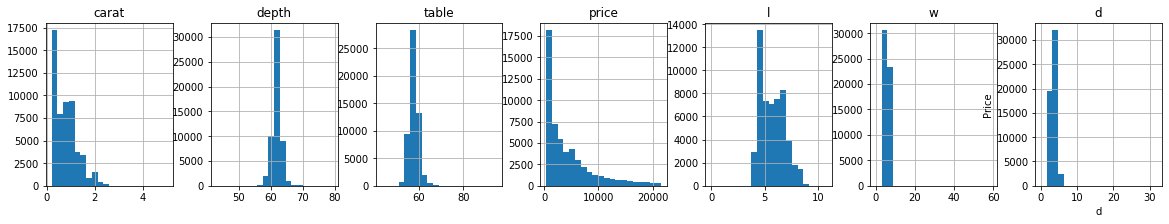

In [927]:
linear_vars = df.select_dtypes(include=[np.number]).columns
display(list(linear_vars))

histplot(df,linear_vars)

#### 3.  Convert to log since features are not normally distributed
<font color = 'navy'><i><b> 1. Check if any value amongst table, depth, l, w, d is 0
    <br> 2. Add 0.01 to all to make non-zero values  </i></b></font>

In [928]:
print('0 values -->', 0 in df.values)
df[linear_vars] = df[linear_vars] + 0.01
print('Filled all 0 values with 0.01. Now any 0 values? -->', 0 in df.values)

0 values --> True
Filled all 0 values with 0.01. Now any 0 values? --> False


<font color = 'navy'><i><b>3. View outliers</b></i></font>

In [929]:
def sorteddf(df, listvar):
    for var in listvar:
        display('sorted by ' + var + ' --> ' + str(list(df[listvar].sort_values(by=var,ascending=False)[var].head())))

sorteddf(df, linear_vars)      

'sorted by carat --> [5.02, 4.51, 4.14, 4.02, 4.02]'

'sorted by depth --> [79.01, 79.01, 78.21000000000001, 73.61, 72.91000000000001]'

'sorted by table --> [95.01, 79.01, 76.01, 73.01, 73.01]'

'sorted by price --> [21646.459999999995, 21640.709999999995, 21626.909999999996, 21624.609999999997, 21623.459999999995]'

'sorted by l --> [10.75, 10.24, 10.15, 10.03, 10.02]'

'sorted by w --> [58.91, 31.810000000000002, 10.549999999999999, 10.17, 10.11]'

'sorted by d --> [31.810000000000002, 8.07, 6.99, 6.7299999999999995, 6.4399999999999995]'

----> We see that there are some outliers for w,d.
<br>Lets visualise those using boxplots

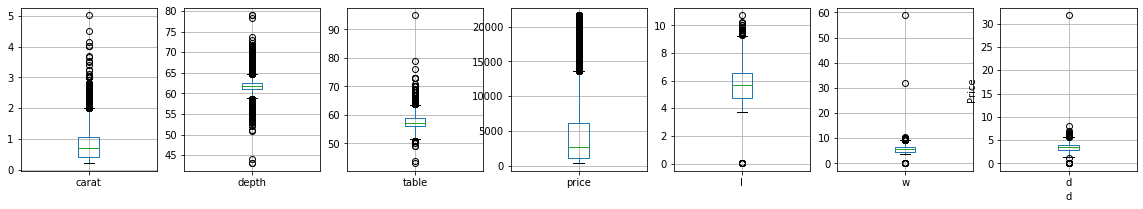

In [930]:
def dfboxplot(df, listvar):
    fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
    counter=0
    for ax in axes:
        df.boxplot(column=listvar[counter], ax=axes[counter])
        plt.ylabel('Price')
        plt.xlabel(listvar[counter])
        counter = counter+1
    plt.show()

dfboxplot(df, linear_vars)


<font color = 'navy'><i><b>Remove outliers using z-score</b></i></font>
* https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
* https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32
* https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

52140


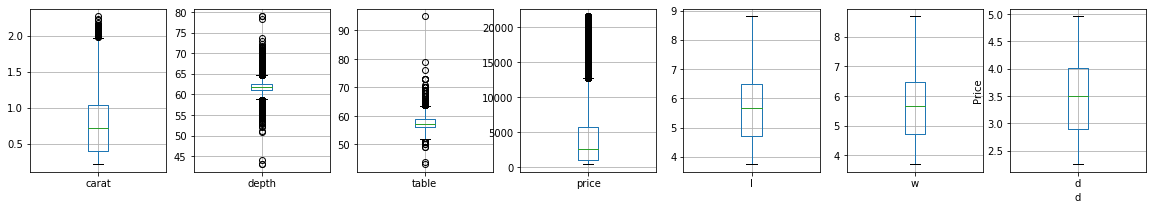

In [931]:
# this removes dataframe's outliers inplace
def removeoutliers(df, listvars, z):
    from scipy import stats
    for var in listvars:
        df1 = df[np.abs(stats.zscore(df[var])) < z]
    return df1

df = removeoutliers(df, linear_vars,2)

# see length of diamonds dataframe with outliers removed
print(len(df))

# view boxplot to confirm removal of outliers
dfboxplot(df, linear_vars)

<font color = 'navy'><i><b>4. Convert to log</b></i></font>

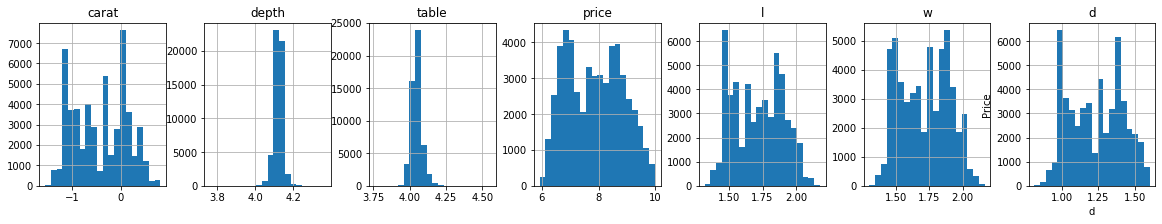

In [932]:
# this log converts dataframe's features inplace
def convertfeatures2log(df, listvars):
    for var in listvars:
        df[var] = np.log(df[var])

convertfeatures2log(df, linear_vars)
histplot(df, linear_vars)


#### As expected, the price vs. carat chart is skewed 

In [933]:
# sns.distplot(df['price'])
# plt.show()

#### Since price is not normally distributed, we will log normal it.


In [934]:
## transforming target variable using numpy.log1p
# df['price_log'] = np.log1p(df['price'])

# dist plot again
# sns.distplot(df['price_log'])
# plt.show()

#### Since price is generally quoted as price per carat in Diamond market, lets use that aspect also.

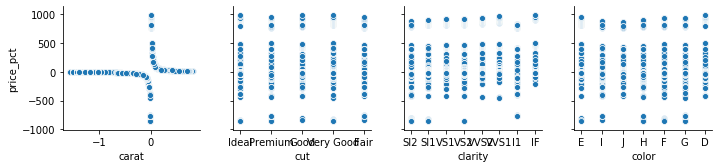

          carat        cut color clarity     depth     table     price  \
0     -1.427116      Ideal     E     SI2  4.119200  4.007515  5.926686   
1     -1.514128    Premium     E     SI1  4.091173  4.111038  5.926686   
2     -1.427116       Good     E     VS1  4.041471  4.174541  5.929749   
3     -1.203973    Premium     I     VS2  4.133726  4.060615  5.950929   
4     -1.139434       Good     J     SI2  4.148043  4.060615  5.953918   
...         ...        ...   ...     ...       ...       ...       ...   
53935 -0.314711      Ideal     D     SI1  4.107754  4.043227  8.061664   
53936 -0.314711       Good     D     SI1  4.144879  4.007515  8.061664   
53937 -0.342490  Very Good     D     SI1  4.140114  4.094511  8.061664   
53938 -0.139262    Premium     H     SI2  4.111038  4.060615  8.061664   
53939 -0.274437      Ideal     D     SI2  4.130516  4.007515  8.061664   

              l         w         d  price_pct  
0      1.376244  1.383791  0.891998  -4.152910  
1      1.3609

In [935]:
df['price_pct']=df['price']/df['carat']
sns.pairplot(df, x_vars=['carat', 'cut', 'clarity', 'color'], y_vars = ['price_pct'])
plt.show()
print(df)


In [936]:
# dist plot again
# sns.distplot(df['price_pct'])
# plt.show()

In [944]:
# now drop price_pct
df.drop(['price_pct'], axis=1, inplace=True)


KeyError: "['price_pct'] not found in axis"

## Data Preprocessing

### 1. Determine mean values of categories of all category columns like cut, clarity and color
* Do a dataframe groupby to find mean. 

* Sort_values sorts result by resulting values, NOT but category label

In [938]:

# Addind a new column in same DF 
# df['price/wt']=df['price']/df['carat']

# IMP: groupby in pandas dataframe
print(df.groupby('cut')['price'].mean().sort_values())
print(df.groupby('color')['price'].mean().sort_values())
print(df.groupby('clarity')['price'].mean().sort_values())

# df = df.drop(['price/wt'], axis=1)


cut
Ideal        7.732822
Very Good    7.883452
Good         7.926996
Premium      8.010951
Fair         8.109674
Name: price, dtype: float64
color
E    7.705330
D    7.742828
F    7.880596
G    7.891297
H    7.960623
I    7.999791
J    8.081601
Name: price, dtype: float64
clarity
VVS1    7.458718
IF      7.539591
VVS2    7.667314
VS1     7.844410
VS2     7.865821
SI1     7.926951
I1      8.008057
SI2     8.149182
Name: price, dtype: float64


### 2. Convert categorical column to numerical column using labelencoder

In [952]:
def convert_catg(df1):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    # Find the columns of object type along with their column index
    object_cols = list(df1.select_dtypes(exclude=[np.number]).columns)
    object_cols_ind = []
    for col in object_cols:
        object_cols_ind.append(df1.columns.get_loc(col))

    # Encode the categorical columns with numbers    
    for i in object_cols_ind:
        df1.iloc[:,i] = le.fit_transform(df1.iloc[:,i])

convert_catg(df)
df.head(3)



,carat,cut,color,clarity,depth,table,price,l,w,d
0,-1.427116,2,1,3,4.119200,4.007515,5.926686,1.376244,1.383791,0.891998
1,-1.514128,3,1,2,4.091173,4.111038,5.926686,1.360977,1.348073,0.841567
2,-1.427116,1,1,4,4.041471,4.174541,5.929749,1.401183,1.406097,0.841567


### 3. Convert this processed data to CSV and store for future predictions on unseen data

In [954]:
df.to_csv('diam_proc.csv')

### 4. Set X and y now 
* NOTE: two quare brackets [[... ]] are needed to create a datarame. 
* Single [] will create a series / array

In [949]:
X_df = df.drop(['price', 'l', 'w', 'd'], axis=1)
display(X_df.head(3))

y_df = df[['price']] # two [[ to create a DF. Single [] will create a series / array
display(y_df.head(3))

,carat,cut,color,clarity,depth,table
0,-1.427116,2,1,3,4.119200,4.007515
1,-1.514128,3,1,2,4.091173,4.111038
2,-1.427116,1,1,4,4.041471,4.174541


,price
0,5.926686
1,5.926686
2,5.929749


### 5.  Determine correlation between price vs all other attributes.
* seems price is highly corr with carat (and dimensions) and fairly with color and clarity, not much with cut
* combining both X (already converted categorical to numerical) and y to form a new dataframe for correlation

> * **df_le = X_df** --> df_le will be like a pointer to X_df. Any change made to df_le will actually be a change to X_df
> * So, df_le = X_df.**copy()** is better

In [941]:
df_le = X_df.copy()

# add a new column in dataframe - join 2 dataframe columns-wise
df_le['price'] = y_df['price'].values
df_le.corr()


,carat,cut,color,clarity,depth,table,price
carat,1.000000,0.017165,0.215271,-0.214794,0.002246,0.194943,0.963616
cut,0.017165,1.000000,0.001026,0.023756,-0.172718,0.158586,0.025828
color,0.215271,0.001026,1.000000,-0.014120,0.038490,0.019935,0.106469
clarity,-0.214794,0.023756,-0.014120,1.000000,-0.039886,-0.087248,-0.096520
depth,0.002246,-0.172718,0.038490,-0.039886,1.000000,-0.305286,-0.022676
table,0.194943,0.158586,0.019935,-0.087248,-0.305286,1.000000,0.158129
price,0.963616,0.025828,0.106469,-0.096520,-0.022676,0.158129,1.000000


#### How cut is correlated to depth and table
<img src="diam_attr.jpg" alt="Diamond Attributes" style="width: 400px;"/>
https://www.gia.edu/diamond-cut/diamond-cut-anatomy-round-brilliant

* Since IDEAL cut has table and depth values along with crown, pavilion, culet etc in a emperically defined range, viewing the correlation of price with table and depth is of not much use. Nevertheless, its here.

In [942]:
df_le[['cut', 'table', 'depth']].corr()

,cut,table,depth
cut,1.000000,0.158586,-0.172718
table,0.158586,1.000000,-0.305286
depth,-0.172718,-0.305286,1.000000


#### Feature scaling - seems not needed here since we have log1p the price

In [943]:
'''from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

 
# why fit_transform to X_train whereas transform to X_test?
# Becasue StandardScaler has to be first fitted to X_train. Then StandardScaler will understand data type and wd need only transform
      
X_df = sc_X.fit_transform(X_df)
X_df[0:3]

'''

'from sklearn.preprocessing import StandardScaler\nsc_X = StandardScaler()\n\n \n# why fit_transform to X_train whereas transform to X_test?\n# Becasue StandardScaler has to be first fitted to X_train. Then StandardScaler will understand data type and wd need only transform\n      \nX_df = sc_X.fit_transform(X_df)\nX_df[0:3]\n\n'

# Run ML Model


#### train test split

In [772]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42)

X_train.head()

,carat,cut,color,clarity,depth,table
3098,0.029559,2,3,0,4.119200,4.025530
41374,-0.653926,1,2,2,4.152771,4.025530
47102,-0.616186,4,3,7,4.130516,3.989169
12152,0.104360,3,1,3,4.122446,4.077707
2378,-1.108663,4,3,5,4.140114,4.060615


In [773]:
# y_test['price'].rename_axis('ID').values

### Linear ML model

In [774]:
from sklearn.linear_model import LinearRegression

reg_all = LinearRegression()
reg_all.fit(X_train,y_train)

y_pred=reg_all.predict(X_test)


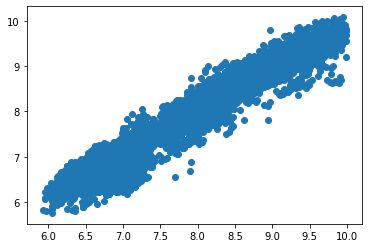

In [775]:
import  matplotlib.pyplot as plt
plt.scatter(y_test,y_pred)

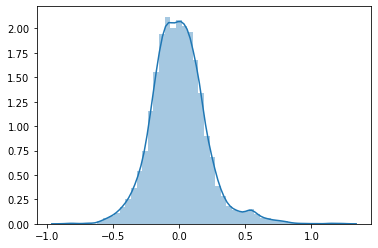

In [776]:
import seaborn as sns
sns.distplot((y_test-y_pred),bins=50);

### Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

In [777]:
from sklearn import metrics

# The following are 

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.1559503946569772
MSE: 0.04259520479890505
RMSE: 0.2063860576659796


### KNN

In [778]:
X_test.head()

,carat,cut,color,clarity,depth,table
51778,-0.478036,4,3,1,4.143293,4.060615
6554,-0.061875,3,5,5,4.138521,4.111038
3170,0.000000,0,5,2,4.106108,4.189806
476,-0.139262,1,2,3,4.163715,4.094511
21555,0.570980,3,5,5,4.133726,4.060615


In [779]:
from sklearn.neighbors import KNeighborsRegressor

reg_all = KNeighborsRegressor(n_neighbors = 8, metric = 'minkowski', p = 2)
reg_all.fit(X_train,y_train)
y_pred=reg_all.predict(X_test)
y_pred[0:3]


array([[8.00704336],
       [8.2916448 ],
       [8.23012118]])

In [780]:
y_test.head()

,price
51778,7.927562
6554,8.451899
3170,8.252592
476,8.083903
21555,9.315408


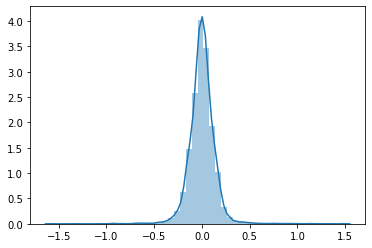

In [781]:
sns.distplot(y_test-y_pred,bins=50)


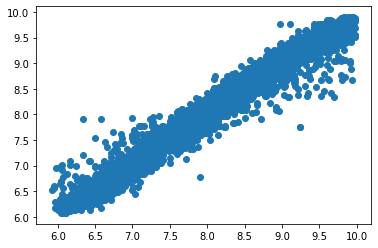

In [782]:
plt.scatter(y_test,y_pred)

In [783]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.09183123668826379
MSE: 0.01796187762432667
RMSE: 0.13402192963961782


## -------------------------------- Now Predict on Pricescope data --------------------------------
Note: I have pulled data from pricescope.com for my personal use. There is no commercial or business use or benefit from this data

In [821]:
ps = pd.read_csv('pricescope2.csv')
ps.drop(['Unnamed: 0'], axis=1, inplace=True)
ps.head(3)

,carat,cut,color,clarity,depth,table,price
0,4.47,Ideal,F,VS1,60.9,57,"$149,865"
1,4.04,Ideal,J,VS2,61.8,56,"$50,804"
2,4.03,Ideal,I,VS2,61.7,57,"$59,872"


### Now do all steps as mentioned in Data pre-processing part.
Click [here](#data_proc) to refer back to Data viz

### Convert price in dollars to integer
1. replace $ with '<blank>' using regex
2. convert to int using astype()
3. array / series to dataframe using pd.DataFrame

In [822]:
priceint=pd.DataFrame(ps['price'].replace('[\$,]', '', regex=True).astype(int))
ps.drop(['price'], axis=1, inplace=True)
ps['price'] = priceint['price'].values
ps.head()

,carat,cut,color,clarity,depth,table,price
0,4.47,Ideal,F,VS1,60.9,57,149865
1,4.04,Ideal,J,VS2,61.8,56,50804
2,4.03,Ideal,I,VS2,61.7,57,59872
3,3.73,Ideal,I,SI1,61.1,57,47217
4,3.31,Ideal,J,VS2,61.8,56,34649


### Check if any null values present

In [823]:
ps.isnull().sum()

carat      0
cut        1
color      0
clarity    0
depth      0
table      0
price      0
dtype: int64

#### Remove the row for null since theres only one such row

In [824]:
indexnames = ps[ps['cut'].isnull()].index
ps.drop(axis=0,index=indexnames,inplace=True)
ps.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
dtype: int64

### Check if all expected datatypes in all columns

In [825]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2271 entries, 0 to 2271
Data columns (total 7 columns):
carat      2271 non-null float64
cut        2271 non-null object
color      2271 non-null object
clarity    2271 non-null object
depth      2271 non-null object
table      2271 non-null object
price      2271 non-null int32
dtypes: float64(1), int32(1), object(5)
memory usage: 133.1+ KB


#### We can see depth, table are _object_ datatype. This means there are some string values present. Lets examine and convert to numeric

In [826]:
print('Percent of non-numeric data in Table -->', len([x for x in ps['table'] if not x.isnumeric()]) / len(ps['table'])*100)
print('Percent of non-numeric data in Depth -->', len([x for x in ps['depth'] if not x.isnumeric()]) / len(ps['table'])*100)

# [x for x in set(ps['depth']) if x.isnumeric()]

Percent of non-numeric data in Table --> 10.127697049757815
Percent of non-numeric data in Depth --> 92.20607661822986


#### Now see if these are floats stored as string or some rubbish values.

In [827]:
def removenotnum(list1):
    notnum = []
    for x in list1:
        try:
            float(x)
        except:
            notnum.append(x)
    return notnum

notnumtable = removenotnum(ps['table'])
print('all rubish values -->', set(notnumtable))
print('Percent of identified rubbish data in Table -->', len(notnumtable) / len(ps['table'])*100)

notnumdepth = removenotnum(ps['depth'])
print('all rubish values -->', set(notnumtable))
print('Percent of identified rubbish data in Depth -->', len(notnumdepth) / len(ps['depth'])*100)


all rubish values --> {'-'}
Percent of identified rubbish data in Table --> 0.5284015852047557
all rubish values --> {'-'}
Percent of identified rubbish data in Depth --> 0.5284015852047557


#### It seems only a single type of rubbish character is stored at 0.5% of data, we can remove those entire rows for now
<font color = "green"> 1. Drop rows with rubbish values for Table and Depth </font

In [828]:
# why the following not working ??
# [row for row in ps if ((row['table'] == '-') & (row['depth'] == '-'))]

# use "&" instead of "and" for multiple conditions... "|" instead of "or"
indexnames = ps[(ps['table'] == '-') | (ps['depth'] == '-')].index
indexnames
ps.drop(axis=0,index=indexnames,inplace=True)
ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2259 entries, 0 to 2271
Data columns (total 7 columns):
carat      2259 non-null float64
cut        2259 non-null object
color      2259 non-null object
clarity    2259 non-null object
depth      2259 non-null object
table      2259 non-null object
price      2259 non-null int32
dtypes: float64(1), int32(1), object(5)
memory usage: 132.4+ KB


<font color = "green"> 2. Check if any row with rubbish values for Table and Depth still present</font

In [829]:
# This SET statement shows whether any '-' still remaining or not
set(ps['table']=="-")

{False}

In [830]:
notnumtable = removenotnum(ps['table'])
print('Percent of identified rubbish data in Table -->', len(notnumtable) / len(ps['table'])*100)

notnumdepth = removenotnum(ps['depth'])
print('Percent of identified rubbish data in Depth -->', len(notnumdepth) / len(ps['depth'])*100)


Percent of identified rubbish data in Table --> 0.0
Percent of identified rubbish data in Depth --> 0.0


#### Convert Table and Depth columns to float datatype

In [831]:
ps['table'] = ps['table'].astype(float)
ps['depth'] = ps['depth'].astype(float)

In [832]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2259 entries, 0 to 2271
Data columns (total 7 columns):
carat      2259 non-null float64
cut        2259 non-null object
color      2259 non-null object
clarity    2259 non-null object
depth      2259 non-null float64
table      2259 non-null float64
price      2259 non-null int32
dtypes: float64(3), int32(1), object(3)
memory usage: 132.4+ KB


### List all categories of the 3 categorical columns: cut, clarity and color
> Remember, making a SET out of a series in a way means finding unique values, since a SET can have only unique values 

In [833]:
print("Cut: ",set(df["cut"]))
print("Color: ",set(df["color"]))
print("Clarity: ",set(df["clarity"]))

Cut:  {'Very Good', 'Fair', 'Ideal', 'Premium', 'Good'}
Color:  {'F', 'H', 'G', 'I', 'J', 'D', 'E'}
Clarity:  {'SI2', 'IF', 'VS1', 'VVS2', 'SI1', 'VVS1', 'VS2', 'I1'}


### Now do all steps as mentioned in Data visualisation part.
Click [here](#data_viz) to refer back to Data viz


#### 1. Pairplot

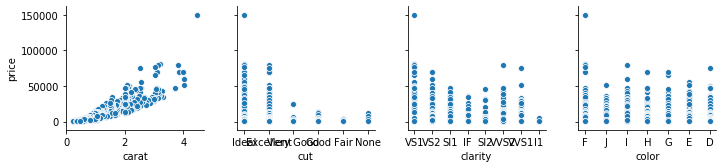

In [834]:
sns.pairplot(ps, x_vars=['carat', 'cut', 'clarity', 'color'], y_vars = ['price'])
plt.show()

#### 2. Histplot

['carat', 'depth', 'table', 'price']

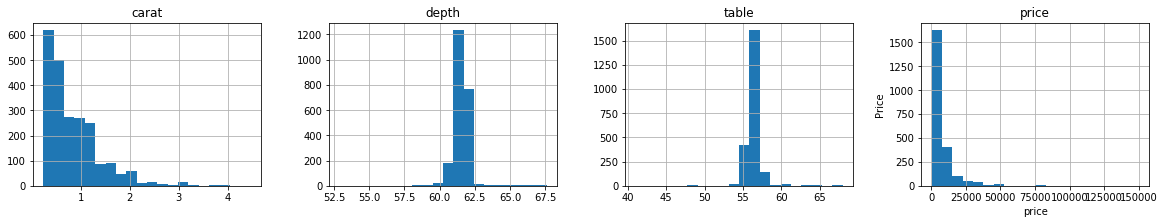

In [835]:
linear_vars_ps = ps.select_dtypes(include=[np.number]).columns
display(list(linear_vars_ps))
histplot(ps,linear_vars_ps)

#### 3. Fill missing / zero values with 0.01

In [836]:
print('0 values -->', 0 in ps.values)
df[linear_vars_ps] = df[linear_vars_ps] + 0.01
print('Filled all 0 values with 0.01. Now any 0 values? -->', 0 in ps.values)

0 values --> False
Filled all 0 values with 0.01. Now any 0 values? --> False


#### 4. Remove outliers

In [837]:
sorteddf(ps, linear_vars_ps)

'sorted by carat --> [4.47, 4.04, 4.03, 4.01, 3.85]'

'sorted by depth --> [67.6, 67.6, 67.4, 67.2, 66.8]'

'sorted by table --> [68.0, 67.0, 67.0, 67.0, 67.0]'

'sorted by price --> [149865, 81359, 80119, 79310, 77384]'

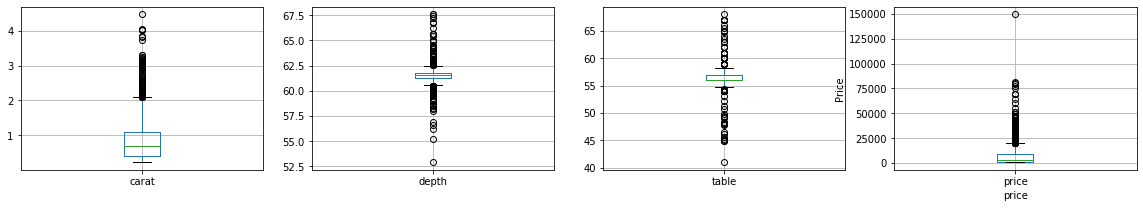

In [838]:
dfboxplot(ps, linear_vars_ps)

In [839]:
removeoutliers(ps,linear_vars_ps, 2)

,carat,cut,color,clarity,depth,table,price
25,2.88,Ideal,J,SI1,60.5,57.0,25417
28,2.72,Ideal,J,SI1,61.8,56.0,23258
35,2.53,Ideal,J,SI1,61.6,55.0,21164
41,2.44,Ideal,J,VS2,61.4,56.0,20707
43,2.41,Ideal,J,SI1,61.7,55.0,19130
...,...,...,...,...,...,...,...
2266,1.67,None,I,SI1,61.0,56.0,11994
2268,1.05,None,I,SI1,61.2,55.0,7560
2269,0.83,None,I,VS2,58.5,41.0,2500
2270,0.60,None,H,VVS2,64.4,49.0,2886


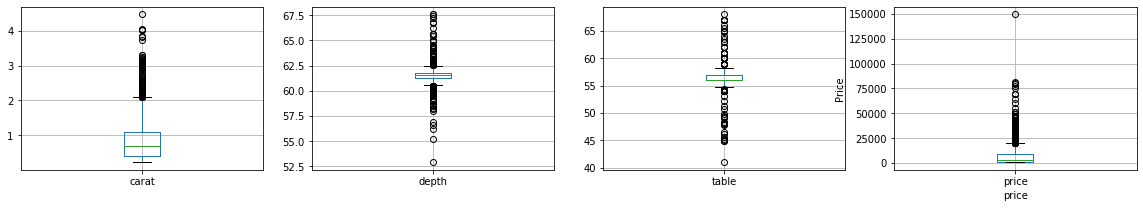

In [840]:
dfboxplot(ps, linear_vars_ps)

In [841]:
convertfeatures2log(ps, linear_vars_ps)

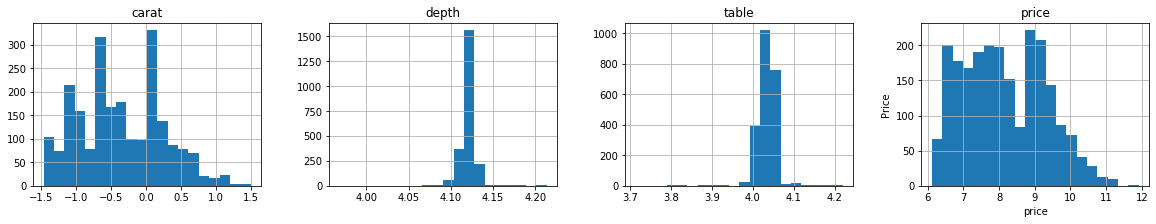

In [842]:
histplot(ps, linear_vars_ps)

In [866]:
ps['carat']

0       1.497388
1       1.396245
2       1.393766
3       1.316408
4       1.196948
          ...   
2266    0.512824
2268    0.048790
2269   -0.186330
2270   -0.510826
2271   -0.776529
Name: carat, Length: 2259, dtype: float64

### Define X and y
* recollect X and y are already converted to log

In [869]:
Xps2 = ps.drop(['price'], axis=1)
Xps2.head()

,carat,cut,color,clarity,depth,table
0,1.497388,Ideal,F,VS1,4.109233,4.043051
1,1.396245,Ideal,J,VS2,4.123903,4.025352
2,1.393766,Ideal,I,VS2,4.122284,4.043051
3,1.316408,Ideal,I,SI1,4.112512,4.043051
4,1.196948,Ideal,J,VS2,4.123903,4.025352


In [870]:
yps2 = ps[['price']]
yps2.head()

,price
0,11.917490
1,10.835730
2,10.999964
3,10.762509
4,10.453024


In [871]:
convert_catg(Xps2)



In [872]:
# Find the columns of object type along with their column index
object_cols = list(ps.select_dtypes(exclude=[np.number]).columns)
object_cols_ind = []
for col in object_cols:
    object_cols_ind.append(ps.columns.get_loc(col))

object_cols

['cut', 'color', 'clarity']

In [873]:
Xps2.head()

,carat,cut,color,clarity,depth,table
0,1.497388,3,2,4,4.109233,4.043051
1,1.396245,3,6,5,4.123903,4.025352
2,1.393766,3,5,5,4.122284,4.043051
3,1.316408,3,5,2,4.112512,4.043051
4,1.196948,3,6,5,4.123903,4.025352


In [874]:
y_pred=reg_all.predict(Xps2)
#y_pred_exp = np.expm1(y_pred)
#y_pred_exp[0:3]
y_pred[0:3]

array([[9.81535334],
       [9.55694633],
       [9.83552535]])

In [879]:
type(y_pred_exp)

numpy.ndarray

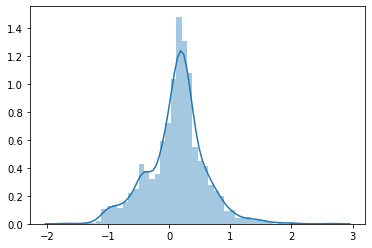

In [894]:
sns.distplot((yps2-y_pred),bins=50)

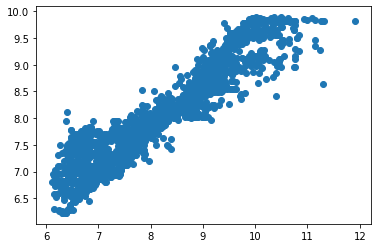

In [895]:
plt.scatter(yps2,y_pred)